# Action Priors in 1D

## Imports

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import datetime

from IPython.core.debugger import set_trace

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# load env
from src.envs.LinearEnv import LinearEnv


# cell magic for reloading imported modules
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment
- State: 
    - $s \in \mathbb{R}^{(1)}$
- Simulates a frog jumping over pools of lava in 1D.
- Should use 1D arrays for states and actions, etc.

In [11]:
%autoreload 2
# instantiate env
env = LinearEnv(5,randomize=True, visualize=False)

## Random Agent

In [12]:
# random agent
def random_agent(obs):
    return {"Action":np.random.uniform(0,1,size=(1,))}

In [13]:
# run a single episode for an agent in the environment and return the rollout

def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []


    done = False
    obs = env.reset()
    for i in range(max_steps):
        observation_list.append(obs.copy())
        out = agent(obs)
        
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action.copy())
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

In [14]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))
def returns(rewards):
    return np.sum(rewards)

$$
\large \nabla_{\theta}J(\theta) \approx \frac{1}{N}\sum \limits_{i = 1}^{N}\left( \nabla_{\theta}\sum \limits_{t = 1}^{T} log\pi_{\theta}(s_{i,t}\mid a_{i,t})\right)\left( \sum \limits_{t = 1}^{T}r(s_{i,t},a_{i,t}) - b\right)
$$

## Training Loop

In [49]:
def train_policy_grad(env, agent, num_epochs=100):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/' + current_time + '/train'
    # test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
       
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    log_reward = 0
    log_reward_list = []
    logging_period = 5
    num_trajectories = 20
    
    for epoch in range(num_epochs):
        
        obs_list = []
        rew_list = []
        actions_list = []
        returns_list = []
        log_probs_list = []
        
        epoch_gradients = []
        for i in range(num_trajectories):
            with tf.GradientTape(persistent=True) as tape:
                traj = get_episode_trajectory(env, agent) # trajectories may vary in length
                
                # lists no longer needed
                obs_list.append(np.stack(traj["Observations"]))
                actions_list.append(traj["Actions"])
                # compute 'reward-to-go'
                # rew_2_go = reward_to_go(rew)
                returns_list.append(np.sum(traj["Rewards"]))
                
                log_probs = agent.action_dist.log_prob(np.interp(traj["Actions"],(-1,1),(0,1)))

                log_prob_sum = tf.reduce_sum(log_probs)
                
            # compute baseline
            baseline = 0

            # compute gradients + update weights
            traj_gradients = []
            for layer in agent_mlp_tf.trainable_variables:
                
                layer_grad_log_sum = -1*tape.gradient(log_prob_sum, layer)*(np.sum(reward_to_go(traj["Rewards"])) - baseline)

                traj_gradients.append(layer_grad_log_sum)
            epoch_gradients.append(traj_gradients)
        
        gradients = []
        for i in range(len(agent.trainable_variables)):
            l_grads = []
            for row, traj_grads in enumerate(epoch_gradients):
                l_grads.append(traj_grads[i])
                       
            gradients.append(tf.reduce_mean(l_grads,axis=0))
        
        
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        
        with train_summary_writer.as_default():
            tf.summary.scalar('Return', np.mean(returns_list), step=epoch)
#             tf.summary.histogram("Action", tf.reduce_mean(out["Action"]) , step=epoch)
            tf.summary.histogram("LogProbability sum", tf.reduce_mean(log_prob_sum) , step=epoch)
#             tf.summary.histogram("Sigma", tf.reduce_mean(out["Scale"]) , step=epoch)
#             tf.summary.histogram("Mu", tf.reduce_mean(out["Loc"]) , step=epoch)
            
            for i,g in enumerate(gradients):
                tf.summary.histogram("gradient_"+str(i),tf.reduce_mean(g), step=epoch)

        
        # log the reward
        log_reward += np.sum(np.mean(returns_list))
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

In [52]:
# load agent
from src.agents.AgentMLPTF import BetaAgent

agent_mlp_tf = BetaAgent()
(episodes, rewards) = train_policy_grad(env, agent_mlp_tf)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training Epoch 0, Averaged Return: -163.7232421875
Training Epoch 5, Averaged Return: -798.7348510742188
Training Epoch 10, Averaged Return: -865.425732421875
Training Epoch 15, Averaged Return: -856.6673095703125
Training Epoch 20, Averaged Return: -823.3108154296875
Training Epoch 25, Averaged Return: -877.2894287109375
Training Epoch 30, Averaged Return: -903.16162109375
Training Epoch 35, Averaged Return: -882.3828979492188
Training Epoch 40, Averaged Return: -870.153466796875
Training Epoch 45, Ave

In [55]:
s = env.reset()
print(np.array(s.ndim))
eps = 20
states = []
rewards_1 = []
for i in range(eps):
    traj = get_episode_trajectory(env, random_agent)
    rewards_1.append(np.sum(traj["Rewards"]))
    

1


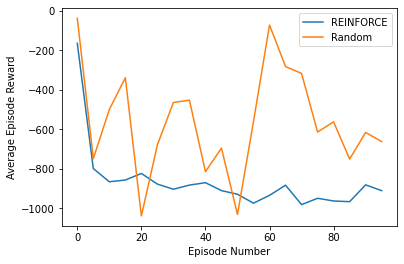

In [56]:
plt.plot(episodes, rewards, label="REINFORCE")
plt.plot(episodes, rewards_1, label="Random")
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.legend()
plt.show()

1


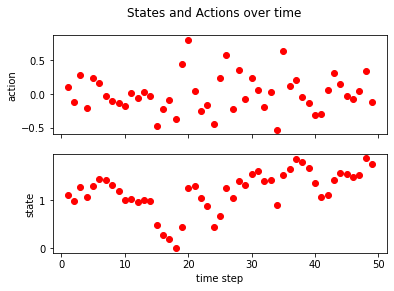

In [30]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

s = env.reset()
print(np.array(s.ndim))
eps = 100
states = []

for i in range(eps):
    
    a = agent_mlp_tf(s)["Action"]
    s,r,done,_ = env.step(a)
    states.append(np.array([s,a]))
    if done:
        break

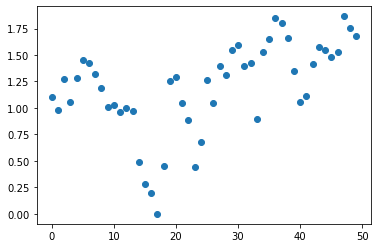

In [31]:
arr = np.array(states)
plt.scatter(list(range(arr.shape[0])),arr[:,0])

(array([ 3.,  3.,  9., 12.,  9.,  6.,  4.,  1.,  2.,  1.]),
 array([-0.52881972, -0.39593305, -0.26304638, -0.13015971,  0.00272696,
         0.13561363,  0.2685003 ,  0.40138697,  0.53427363,  0.6671603 ,
         0.80004697]),
 <BarContainer object of 10 artists>)

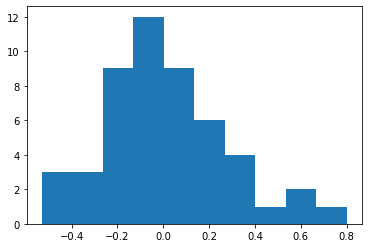

In [32]:
plt.hist(arr[:,1])

In [34]:
arr[:,0]

array([[1.09961885],
       [0.98330042],
       [1.26999753],
       [1.05813406],
       [1.28685379],
       [1.4484547 ],
       [1.42353711],
       [1.32425533],
       [1.18903123],
       [1.00501776],
       [1.02481764],
       [0.96545906],
       [0.99912104],
       [0.9743021 ],
       [0.49388741],
       [0.2784256 ],
       [0.19302302],
       [0.        ],
       [0.45013434],
       [1.25018131],
       [1.29462902],
       [1.04404767],
       [0.88540426],
       [0.43982745],
       [0.68045019],
       [1.2598574 ],
       [1.0429404 ],
       [1.39300582],
       [1.31566481],
       [1.54643011],
       [1.59790523],
       [1.39957961],
       [1.42463322],
       [0.8958135 ],
       [1.52666709],
       [1.65057185],
       [1.85013967],
       [1.79794047],
       [1.65971134],
       [1.3494707 ],
       [1.0553966 ],
       [1.11110036],
       [1.41792059],
       [1.57192421],
       [1.54869978],
       [1.48132564],
       [1.52878502],
       [1.865